# Pepper Bell Disease Classification

## Introduction

Plants are a significant source of energy. Crop protection and production can be increased using the early and accurate diagnosis of plant diseases.In the old-fashioned environment, the identification is processed whether the plant leaf is healthy or infected either by visual observation or by testing leaves in the laboratory. The visual identification is done by the experts of the plant domain but opinion may vary from expert to expert. Testing of the plant leaf in the laboratory is a very time consuming and strenuous process and hence results may not come on time.

In today's Agriculture, leaf disease is a major issue. It hinders the natural growth of the plant. It will lowers the quality of agricultural products. Leaf disease can be developd as a result of bacterial, fungal, or other causes. Finding and detecting sick plants in the open eye takes a long time.   

 Capsicum (Capsicum annum) is the most used food crop in the world. Bell pepper bacterial spot (a fungal disease in capsicum) has caused a momentous economic and commercial loss and just by eliminating 20% of this bacterial infection, the farmers may benefit from an extraordinary profit. Therefore, early detection and identification of capsicum bacterial diseases play the utmost important role to take timely measures for the quality of the plant.
There are numerous ways to perceive plant pathologies. Some plants have no visible symptoms of diseases associated with them or diseases may appear only when too late to cure. So it is necessary to perform a classy analysis of the plant diseases in the laboratories by the experts using powerful microscopes or employing different electromagnetic spectrum that is not visible to humans.  

The population is increasing day by day and the importance of agriculture is also increasing in parallel. There is an attempt to apply machine machine learning and deep learning methods in agriculture under the name of smart farm technologies both to increasing agricultural production solve some challenges of agriculture.  Some of the machine learning challenges include Data availability and quality. Agricultural data can be complex, heterogenous and difficlut to collect. ML algorithms require large amount of high quality data to produce accurate predictions, which can be a challenge in agriculture, particularly for small scale farmers.

Computer vision, artificial intelligence, machine learning and deep learning techniques are more popular research areas for object detection and classification from images, text and videos.  Digital image processing technique minimized the inaccurate manual disease detection and improve the accuracy, feasibility and efficiency to predict the disease on a time from a plant. 

The first aim of the current project was the collection of a sufficient capsicum image dataset from the field and then classifies the images into two categories (Bacterial spot images and healthy images).

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


### Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Village",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

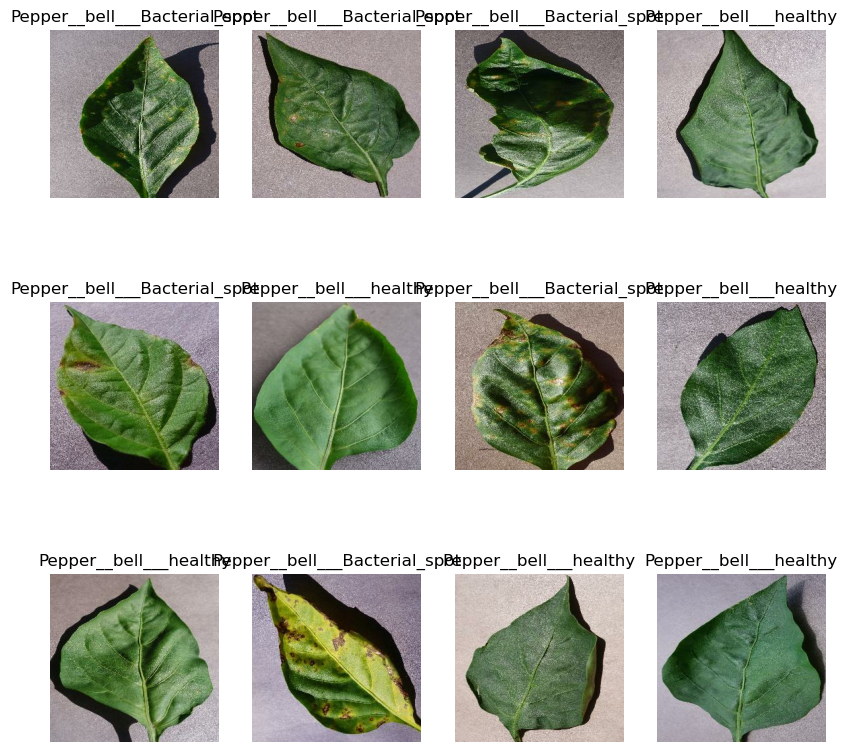

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [7]:
len(dataset)

78

In [8]:
train_size = 0.8
len(dataset)*train_size

62.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

24

In [11]:
val_size=0.1
len(dataset)*val_size

7.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

18

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

62

In [17]:
len(val_ds)

7

In [18]:
len(test_ds)

9

### Cache, Shuffle, and Prefetch the Dataset

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks.**

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
62/62 [==============================] - 112s 2s/step - loss: 0.7010 - accuracy: 0.5614 - val_loss: 0.6072 - val_accuracy: 0.7723
Epoch 2/50
62/62 [==============================] - 114s 2s/step - loss: 0.4359 - accuracy: 0.8253 - val_loss: 0.5491 - val_accuracy: 0.9018
Epoch 3/50
62/62 [==============================] - 112s 2s/step - loss: 0.2816 - accuracy: 0.9068 - val_loss: 0.5204 - val_accuracy: 0.9062
Epoch 4/50
62/62 [==============================] - 93s 1s/step - loss: 0.2040 - accuracy: 0.9455 - val_loss: 0.2243 - val_accuracy: 0.9464
Epoch 5/50
62/62 [==============================] - 100s 2s/step - loss: 0.0889 - accuracy: 0.9755 - val_loss: 0.1311 - val_accuracy: 0.9732
Epoch 6/50
62/62 [==============================] - 101s 2s/step - loss: 0.0413 - accuracy: 0.9908 - val_loss: 0.2341 - val_accuracy: 0.9732
Epoch 7/50
62/62 [==============================] - 97s 2s/step - loss: 0.0613 - accuracy: 0.9878 - val_loss: 0.1037 - val_accuracy: 0.9732
Epoch 8/50
62/6

In [30]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 6s 620ms/step - loss: 0.0282 - accuracy: 0.9896


**You can see above that we get 98.96% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [31]:
scores

[0.028230948373675346, 0.9895833134651184]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [32]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 62}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [35]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

50

In [37]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.7009953260421753,
 0.4359014630317688,
 0.28159207105636597,
 0.20402802526950836,
 0.08890046924352646]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

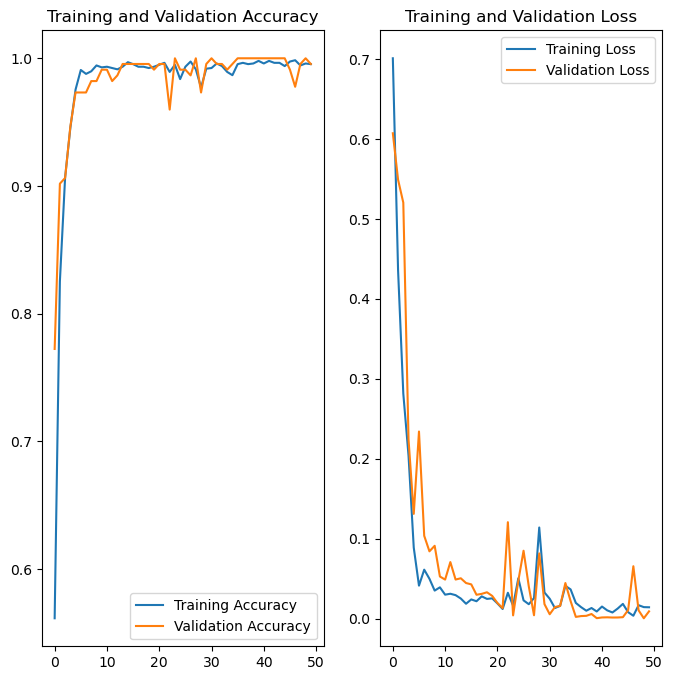

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Pepper__bell___healthy
1/1 [==============================] - 3s 3s/step
predicted label: Pepper__bell___healthy


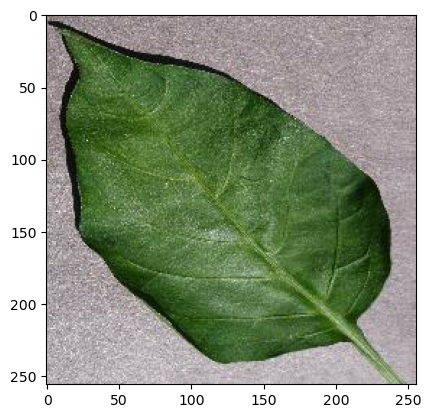

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 20ms/step


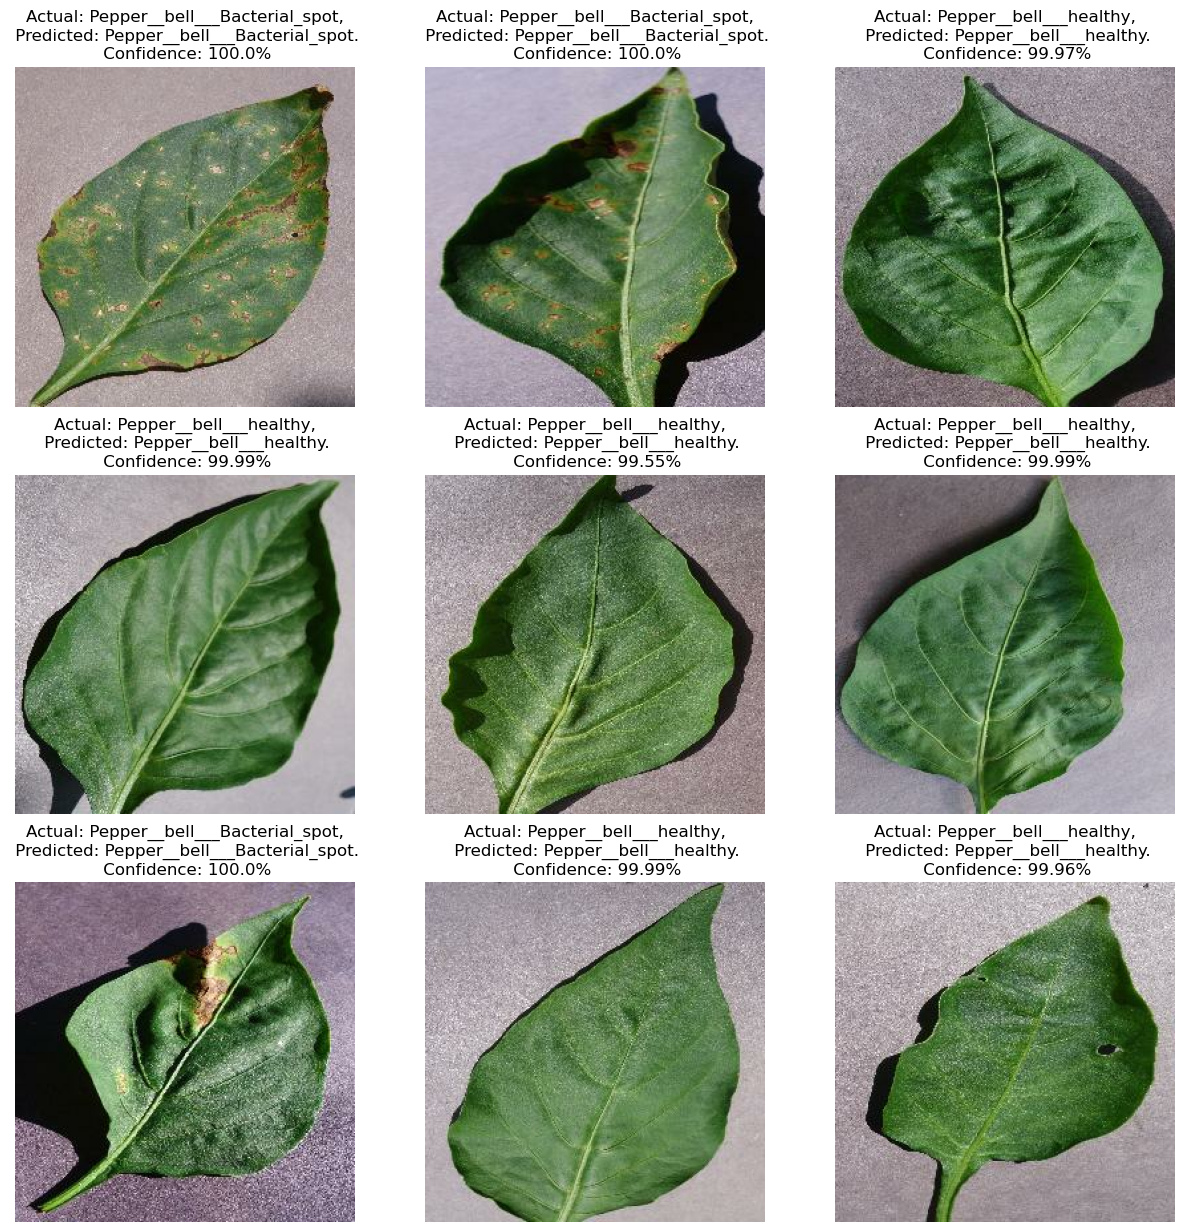

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [46]:
import os
model_version=max([int(i) for i in os.listdir("/Users/kishoreu/Downloads/Plant Vllage/training/models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1/assets


INFO:tensorflow:Assets written to: ../models/1/assets


In [47]:
model.save("../potatoes.h5")

/Users/kishoreu/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
